In [19]:
import pandas as pd
import numpy as np
from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate
import plotly.graph_objects as go

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output,State

import os
if os.path.split(os.getcwd())[-1]=='notebooks':
    os.chdir("../")

'Your base path is at: '+os.path.split(os.getcwd())[-1]

sns.set(style="whitegrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

# Data Preparation

In [20]:
data_url ="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

pd_raw = pd.read_csv(data_url)
time_idx=pd_raw.columns[4:]
df_plot = pd.DataFrame({
    'date':time_idx})
df_plot
pd_raw[pd_raw['Country/Region']=='Germany'].iloc[:,4::].sum(axis=0)
country_list = pd_raw['Country/Region'].unique()
for each in country_list:
    df_plot[each]=np.array(pd_raw[pd_raw['Country/Region']==each].iloc[:,4::].sum(axis=0))
    
time_idx=[datetime.strptime( each,"%m/%d/%y") for each in df_plot.date] # convert to datetime
time_str=[each.strftime('%Y-%m-%d') for each in time_idx] # convert back to date ISO norm (str)
df_plot['date']=time_idx
type(df_plot['date'][0])
df_plot.to_csv('./data/processed/COVID_small_flat_table.csv',sep=';',index=False)


In [21]:
df_analyse=pd.read_csv('./data/processed/COVID_small_flat_table.csv',sep=';')  
#df_analyse.sort_values('date',ascending=True)

In [22]:
df_analyse

,date,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
0,2020-01-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2,2020-01-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
3,2020-01-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
4,2020-01-26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,2022-07-24,184587,304890,266839,45326,102301,11,8736,9507562,424400,...,967808,242691,11723,532902,10767948,672039,535,11849,328550,256254
915,2022-07-25,184819,305123,266916,45326,102301,11,8736,9507562,425365,...,967808,242747,11723,533195,10768844,672039,535,11849,329483,256270
916,2022-07-26,185086,306789,267010,45326,102301,11,8741,9507562,425365,...,969803,242811,11723,533195,10770304,682096,535,11849,329483,256284
917,2022-07-27,185272,308050,267096,45326,102301,11,8741,9507562,425365,...,969803,242879,11723,533379,10772980,682096,535,11849,329483,256315


In [23]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate

## beta/gamma is the basic reproduction number, <1 means no spread virus


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

In [24]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


In [25]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

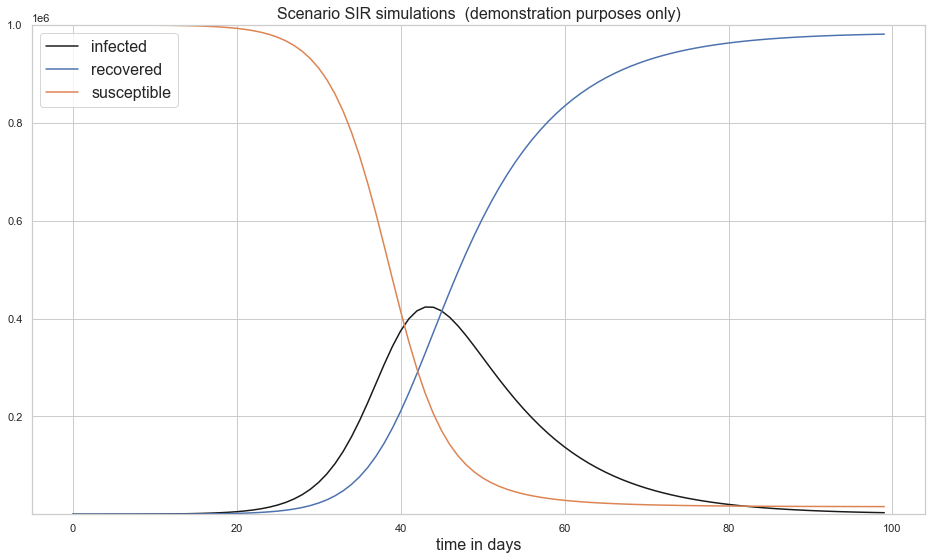

In [26]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Scenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

In [27]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [28]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [29]:
ydata = propagation_rates.infected
t=np.arange(len(ydata))

In [30]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])


<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:18: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.



standard deviation errors :  [0.00087012 0.00074077]  start infect: 27.299823600000003
Optimal parameters: beta = 0.37337789054916876  and gamma =  0.09619940540430044


In [31]:
fitted=fit_odeint(t, *popt)

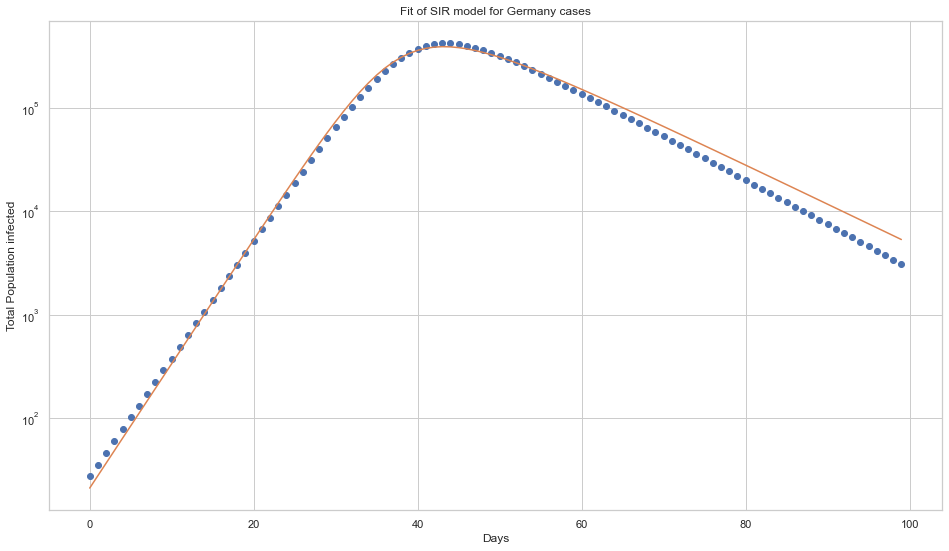

Optimal parameters: beta = 0.37337789054916876  and gamma =  0.09619940540430044
Basic Reproduction Number R0  3.8812910431198726
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [32]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
#plt.semilogy(fitted)

plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Total Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

In [33]:
df_country=df_analyse.columns
df_country = np.array(df_country.drop("date"))
print(df_country)

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Antarctica'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burma' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chad' 'Chile' 'China' 'Colombia' 'Comoros' 'Congo (Brazzaville)'
 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' 'Denmark' 'Diamond Princess' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Holy See'
 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica

In [34]:
N0=1000000 #max susceptible population 
beta=0.4   # infection spread 
gamma=0.1  # recovery rate

df_data=df_analyse[58:]
t=np.arange(df_data.shape[0])
R0=0
    
for country in df_country: 
    y_data=np.array(df_data[df_data[country]>0][country])
    t=np.arange(len(y_data))

    I0=y_data[0]
    S0=N0-I0
    popt=[0.4,0.1]
    fit_odeint(t, *popt)
    popt, pcov = optimize.curve_fit(fit_odeint, t, y_data, maxfev=100000)
    perr = np.sqrt(np.diag(pcov))
    fitted=fit_odeint(t, *popt)
    fitted_pad = np.concatenate((np.zeros(df_data.shape[0]-len(fitted)) ,fitted))
    df_data[country + '_fitted'] = fitted_pad

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarni

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:18: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:18: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalar

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:18: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set 

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:18: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\My

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalar

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set 

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalar

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set 

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarni

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:18: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\My

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Mywork

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:18: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information

<ipython-input-34-e6b159f2feb1>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

<ipython-input-27-16f200073f8a>:16: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:17: RuntimeWarning:

overflow encountered in double_scalars

<ipython-input-27-16f200073f8a>:18: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\Public\Myworkml\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Illegal input detected (internal error). Run with full_output = 1 to get quantitative information

In [35]:
df_data = df_data.reset_index(drop=True)

In [ ]:
# creating dashboard app containig plotting of source and fitted SIR curve data for whole dataset
fig = go.Figure()
app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  SIR Model Dashboard
    * The first plot shows the confirmed cases with time.
    * The second plot shows the predicted cases with time. 
    
    '''),

    dcc.Markdown('''
    ## Select Country
    '''),
    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': each,'value':each} for each in df_data.columns[1:200]],
        value=['Germany','US', 'Canada'], # which are pre-selected
        multi=True),
    dcc.Graph(figure=fig, id='main_window_slope')])


@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')])
def update_figure(country_list):
    v = 0
    my_yaxis={'type':"log",'title':'Confirmed'}
    traces = []
    for each in country_list:
        traces.append(dict(x=df_data['date'],y=df_data[each],
                                mode='line',name=each))
        traces.append(dict(x=df_data['date'],
                                y=df_data[each+'_fitted'],
                                mode='lines+markers',name=each+'_simulated'))

        v = v+1
    return {
            'data': traces,
            'layout': dict (
                width=1280,height=720,
                xaxis={'title':'Time','tickangle':-45,'nticks':20,
                'tickfont':dict(size=14,color="#0c6887"),},yaxis=my_yaxis)}

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
